In [149]:
from imports import *
import scikit_posthocs as sp
from statannotations.Annotator import Annotator

def discard_border(state, t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)


def compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=None, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons, start=start, stop=stop,binSize = binSize, nbins=nbins, as_Tsd=True)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.mean(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
    i_spikes = np.mean(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
    
    eib = e_spikes / (e_spikes + i_spikes)
    # print('ispikes',i_spikes)
    eib[~np.isfinite(eib)] = np.nan
    
    if as_tsd: eib = nts.Tsd(activity.times(),eib)
    return eib


def eib_intervals_old(neurons,metadata,stru,intervals):

    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')

    activity = bk.compute.bin_by_intervals(neurons,intervals,as_Tsd=True)
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)

    return (e_spikes)/(e_spikes+i_spikes)

def eib_intervals(neurons,metadata,stru,intervals,nbins = None,binSize = None,norm = False,baseline = None,as_tsd = False):
    if len(intervals) == 0:
        eib = np.empty(shape = nbins)
        eib.fill(np.nan)
        return eib
    if norm:
        if baseline is None:
            tmp_eib = compute_eib(neurons,metadata,start = 0,stop = None,binSize = 10 ,stru = stru)
        else:
            tmp_eib = compute_eib(neurons,metadata,start = 0,stop = None,binSize = 10 ,stru = stru,as_tsd=True).restrict(baseline)
        mean = np.nanmean(tmp_eib)
        std = np.nanstd(tmp_eib)

    intervals_eib_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        eib_ = compute_eib(neurons,metadata,start = s,stop = e,binSize = binSize,nbins = nbins,stru = stru,as_tsd = as_tsd)
        if norm: eib_ = (eib_-mean)/std
        intervals_eib_matrix.append(eib_)
    if nbins == 1:
        intervals_eib_matrix = np.hstack(intervals_eib_matrix)
    return intervals_eib_matrix



In [172]:
def main(base_folder, local_path, *args, **kwargs):
    print(kwargs)
    stru = kwargs['stru']
    nbins = kwargs['nbins']
    binSize = kwargs['binSize']
    min_duration_epoch = kwargs['min_duration']
    time_from_border = kwargs['time_from_border']
    norm = kwargs['norm']
    baseline = kwargs['baseline']
    as_tsd = kwargs['as_tsd']

    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()

    if np.sum((metadata.Region == stru) & (metadata.Type == 'Int')) < 3:
        raise IndexError('Less than 3 interneurons')

    # if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<11:
    #     raise Exception('Not Enough Neurons')

    states = bk.load.states(True)
    for s in ['wake', 'drowsy']:
        states.pop(s)

    # phasic_tonic = bk.load.intervals('phasic_tonic')

    # for s in phasic_tonic:
    #     states[s] = phasic_tonic[s]

    if baseline == 'All':
        baseline_intervals = states['REM'].union(
            states['REM']).union(states['WAKE_HOMECAGE'])
    elif baseline == 'epochs':
        norm = False
        baseline_intervals = None
    elif baseline is not None:
        baseline_intervals = states[baseline]
    else:
        baseline_intervals = None

    all_average_eib = {}
    df = pd.DataFrame()
    for k, state in states.items():
        state = state.drop_short_intervals(
            min_duration_epoch[k], 's').reset_index(drop=True)
        # We remove what is close to transition as the sleep scoring might not be perfect
        discard_border(state, time_from_border[k])
        
        all_average_eib[k] = eib_intervals(neurons,
                                           metadata,
                                           stru,
                                           state,
                                           nbins[k],
                                           norm=norm,
                                           baseline=baseline_intervals,
                                           binSize=binSize,
                                           as_tsd=as_tsd)
        if nbins[k] == 1:
            df_ = pd.DataFrame(all_average_eib[k], columns=['EIB'])
        elif nbins[k] == 3:
            df_ = pd.DataFrame(all_average_eib[k], columns=[
                               'First', 'Middle', 'Last'])
        else:
            df_ = pd.DataFrame([all_average_eib[k]]).T
            df_.columns = ['Dynamic']

        df_['State'] = k
        df = pd.concat((df, df_))
    if baseline == 'epochs':
        print('yes')
        if 'First' in df.columns:
            kwargs['nbins'] = {'REM': 1,
                               'NREM': 1,
                               'WAKE_HOMECAGE': 1}
            kwargs['norm'] = False
            kwargs['baseline'] = None
            df_ = main(base_folder, local_path, **kwargs)
            mean = np.mean(df_['EIB'])
            std = np.std(df_['EIB'])
            for c in ['First', 'Middle', 'Last']:
                df[c] = (df[c]-mean)/std

        elif 'Dynamic' in df.columns:
            if isinstance(df['Dynamic'].iloc[0],nts.Tsd):
                # return df
                df['Dynamic'] = df['Dynamic'].apply(bk.compute.nts_zscore)
            df['Dynamic'] = df['Dynamic'].apply(scipy.stats.zscore)
        else:
            mean = np.mean(df['EIB'])
            std = np.std(df['EIB'])
            df['EIB'] = (df['EIB']-mean)/std
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df['nPyr'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Pyr'))
    df['nInt'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Int'))

    return df


In [139]:
def merge(batch_output):
    states_eib = {'REM': [],
                  'NREM': [],
                  'WAKE_HOMECAGE': []}
    metadata = pd.DataFrame()
    for k, b in batch_output.items():
        metadata = pd.concat((metadata, b[1]))
        for kk, state_eib in b[0].items():
            states_eib[kk].append(state_eib)
    for k, state_eib in states_eib.items():
        states_eib[k] = np.hstack(state_eib)
    return states_eib


## Compare Between State

In [140]:
kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': 1,
              'NREM': 1,
              'WAKE_HOMECAGE': 1,
              'phREM': 1,
              'toREM': 1
          },
          'binSize':None,
          'as_tsd':False,
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200,
              'phREM': 0,
              'toREM': 0
          },
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE': 0,
           'phREM': 0,
           'toREM': 0
           },
          'norm': True,
          'baseline': 'epochs'
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
# a = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)

df_norm = pd.concat(batch)


# kwargs = {'stru': 'BLA',
#           'nbins':
#           {
#               'REM': 1,
#               'NREM': 1,
#               'WAKE_HOMECAGE': 1
#           },
#           'min_duration':
#           {
#               'REM': 30,
#               'NREM': 200,
#               'WAKE_HOMECAGE': 200
#           },
#           'time_from_border':
#           {'REM': 0,
#            'NREM': 0,
#            'WAKE_HOMECAGE': 0
#            },
#           'norm': False,
#           'baseline': None
#           }
# bk.load.current_session_linux()
# batch, metadata = bk.load.batch(main, **kwargs)
# df_no_norm = pd.concat(batch)


100%|██████████| 61/61 [03:01<00:00,  2.97s/it]

['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 181.3966236114502
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'R

In [141]:
sess = df_norm.reset_index()['level_0'].unique()
len(sess)
nPyr = []
nInt = []
for s in sess:
    nPyr.append(df_norm.loc[s].nPyr.unique()[0])
    nInt.append(df_norm.loc[s].nInt.unique()[0])

n_neurons_crit_pyr = pd.DataFrame(np.array([sess,nPyr,nInt]).T,columns=['Sess','nPyr','nInt'])
# pd.merge(n_neurons_crit_pyr,n_neurons_crit_inter,'outer',on='Sess',suffixes=['PyrCriteria','IntCriteria'])

In [142]:
df = df_norm
df = df.reset_index(level=0,names = 'session')
df = df.reset_index()
print(scipy.stats.kruskal(df['EIB'][df.State == 'NREM'],
                    df['EIB'][df.State == 'REM'],
                    df['EIB'][df.State == 'WAKE_HOMECAGE']))
pairs = list(itertools.combinations(df.State.unique(),2))

KruskalResult(statistic=91.33479000838452, pvalue=1.468596019590208e-20)


In [144]:
df.groupby('State').apply(lambda x:len(x))

State
NREM             317
REM              261
WAKE_HOMECAGE    234
dtype: int64

In [115]:
sp.posthoc_dunn(df,group_col='State',val_col='EIB',p_adjust='bonferroni')

,NREM,REM,WAKE_HOMECAGE,phREM,toREM
NREM,1.000000,0.007037,0.000017,0.000041,0.000235
REM,0.007037,1.000000,1.000000,1.000000,1.000000
WAKE_HOMECAGE,0.000017,1.000000,1.000000,1.000000,0.365619
phREM,0.000041,1.000000,1.000000,1.000000,1.000000
toREM,0.000235,1.000000,0.365619,1.000000,1.000000


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.810e-06 U_stat=3.847e+04
NREM vs. REM: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.059e-06 U_stat=5.102e+04
NREM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.242e-20 U_stat=5.439e+04


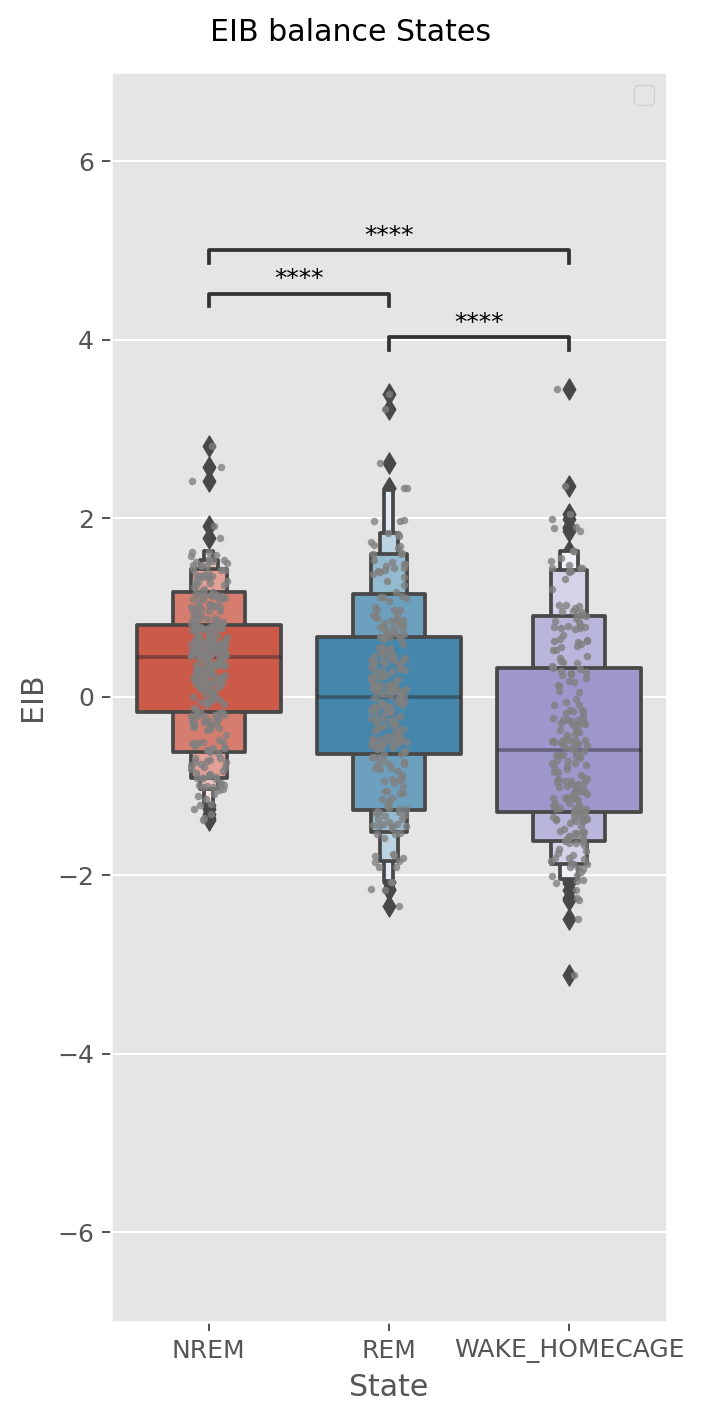

In [147]:
fig, ax = plt.subplots(1, 1, dpi=180, figsize=(4, 8))
plotting_params = {'data': df,
                   'y': 'EIB',
                   'x': 'State',
                   'order': ['NREM', 'REM', 'WAKE_HOMECAGE'],
                   'ax': ax}

sns.boxenplot(**plotting_params)
sns.stripplot(**plotting_params, color='grey', size=3, alpha=0.8)
annotator = Annotator(pairs=pairs, **plotting_params)
annotator.configure(test="Mann-Whitney",
                    comparisons_correction='Bonferroni').apply_and_annotate()
plt.ylim(-7,7)
plt.suptitle('EIB balance States')
ax.legend([])
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/BLA_EIB_Different_States/eib_states.svg')


## Compare between thirds

In [156]:
kwargs = {'stru': 'BLA',
          'binSize':None,
          'as_tsd':False,
          'nbins':
          {
              'REM': 3,
              'NREM': 3,
              'WAKE_HOMECAGE': 3
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'norm': True,
          'baseline': 'epochs'
          }
bk.load.current_session_linux()
# df = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
batch, metadata = bk.load.batch(main, **kwargs)

# df_norm = pd.concat(batch)
# kwargs = {'stru': 'BLA',
#           'nbins':
#           {
#               'REM': 3,
#               'NREM': 3,
#               'WAKE_HOMECAGE': 3
#           },
#           'min_duration':
#           {
#               'REM': 30,
#               'NREM': 200,
#               'WAKE_HOMECAGE': 200
#           },
#           'time_from_border':
#           {'REM': 5,
#            'NREM': 20,
#            'WAKE_HOMECAGE': 20
#            },
#           'norm': False,
#           'baseline': 'All'
#           }
# bk.load.current_session_linux()
# batch, metadata = bk.load.batch(main, **kwargs)
# df_not_norm = pd.concat(batch)

100%|██████████| 61/61 [04:00<00:00,  3.95s/it]

['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 240.98433017730713
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', '

In [157]:
df_norm = pd.concat(batch)

In [158]:
pairs = [
    [('NREM', 'First'), ('NREM', 'Middle')],
    [('NREM', 'First'), ('NREM', 'Last')],
    [('NREM', 'Middle'), ('NREM', 'Last')],

    # [('REM', 'First'), ('REM', 'Middle')],
    # [('REM', 'First'), ('REM', 'Last')],
    # [('REM', 'Middle'), ('REM', 'Last')],

    # [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Middle')],
    # [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Last')],
    # [('WAKE_HOMECAGE', 'Middle'), ('WAKE_HOMECAGE', 'Last')]
]

df = df_norm
for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
    print(state,scipy.stats.friedmanchisquare(df['First'][df.State == state],
                                  df['Middle'][df.State == state],
                                  df['Last'][df.State == state]))

NREM FriedmanchisquareResult(statistic=36.41640378548891, pvalue=1.2367399577324687e-08)
REM FriedmanchisquareResult(statistic=1.8467432950187685, pvalue=0.3971776379921535)
WAKE_HOMECAGE FriedmanchisquareResult(statistic=2.111111111111313, pvalue=0.3479990407922201)


In [ ]:
pairs = [
    [('NREM', 'First'), ('NREM', 'Middle')],
    [('NREM', 'First'), ('NREM', 'Last')],
    [('NREM', 'Middle'), ('NREM', 'Last')],

    # [('REM', 'First'), ('REM', 'Middle')],
    # [('REM', 'First'), ('REM', 'Last')],
    # [('REM', 'Middle'), ('REM', 'Last')],

    # [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Middle')],
    # [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Last')],
    # [('WAKE_HOMECAGE', 'Middle'), ('WAKE_HOMECAGE', 'Last')]
]

df = df_norm
for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
    print(state,scipy.stats.friedmanchisquare(df['First'][df.State == state],
                                  df['Middle'][df.State == state],
                                  df['Last'][df.State == state]))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NREM_First vs. NREM_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.314e-02 Stat=2.055e+04
NREM_Middle vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:8.827e-04 Stat=1.929e+04
NREM_First vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:8.244e-06 Stat=1.754e+04


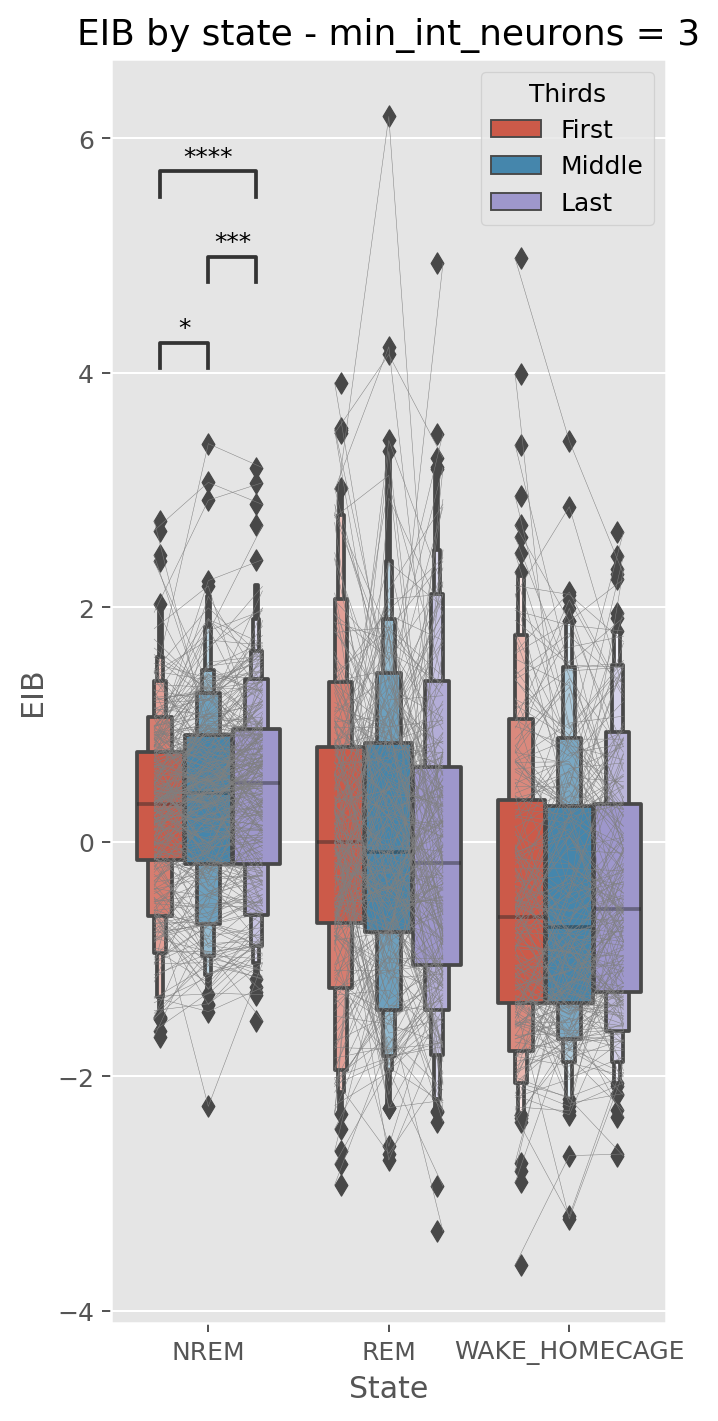

In [159]:
df = df_norm
df_melt = df.melt(id_vars=['Rat','Day','State'],var_name='Thirds',value_name='EIB',value_vars=['First','Middle','Last'])
fig,ax = plt.subplots(1,1,figsize=(4,8),dpi = 180)
plotting_params = {'data': df_melt,
                   'y': 'EIB',
                   'x':'State',
                   'dodge':True,
                   'hue':'Thirds',
                   'order':['NREM','REM','WAKE_HOMECAGE'],
                   'ax':ax}
sns.boxenplot(**plotting_params)
annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Wilcoxon",comparisons_correction = 'Bonferroni').apply_and_annotate()

for i,s in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    values = np.array((df.First[df.State == s],df.Middle[df.State == s],df.Last[df.State == s]))
    n_values = values.shape[1]
    
    args_sampling = np.random.choice(n_values,n_values,replace=False)
    x = np.array([[i-0.30]*n_values,[i]*n_values,[i+0.30]*n_values])
    plt.plot(x[:,args_sampling],values[:,args_sampling],'grey',linewidth =0.2)

# plt.ylim(0,1.25)
plt.title(f'EIB by state - min_int_neurons = 3')
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/BLA_EIB_Different_States/eib_states_thirds.svg')


## Assess the Exact dynamic of EIB during each states :

In [176]:
kwargs = {'stru': 'BLA',
          'binSize':None,
          'as_tsd':False,
          'nbins':
          {
              'REM': 12,
              'NREM': 30,
              'WAKE_HOMECAGE': 30
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'norm': True,
          'baseline': 'epochs'
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
df_norm = pd.concat(batch)

100%|██████████| 61/61 [02:04<00:00,  2.05s/it]

['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 124.75721883773804
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', '

In [182]:
all_eib

array([[ 0.        ,  1.        ,  2.        , ..., 27.        ,
        28.        , 29.        ],
       [ 0.42480187,  1.37682678,  0.96505452, ..., -1.28212001,
        -0.30247061, -0.35709852]])

NREM
R2 0.009559144468478052
pValue (bonfer) 3.665196076806414e-21
REM
R2 0.0025440002207165373
pValue (bonfer) 0.014255129323834026
WAKE_HOMECAGE
R2 0.000768002839350296
pValue (bonfer) 0.06070414356038245


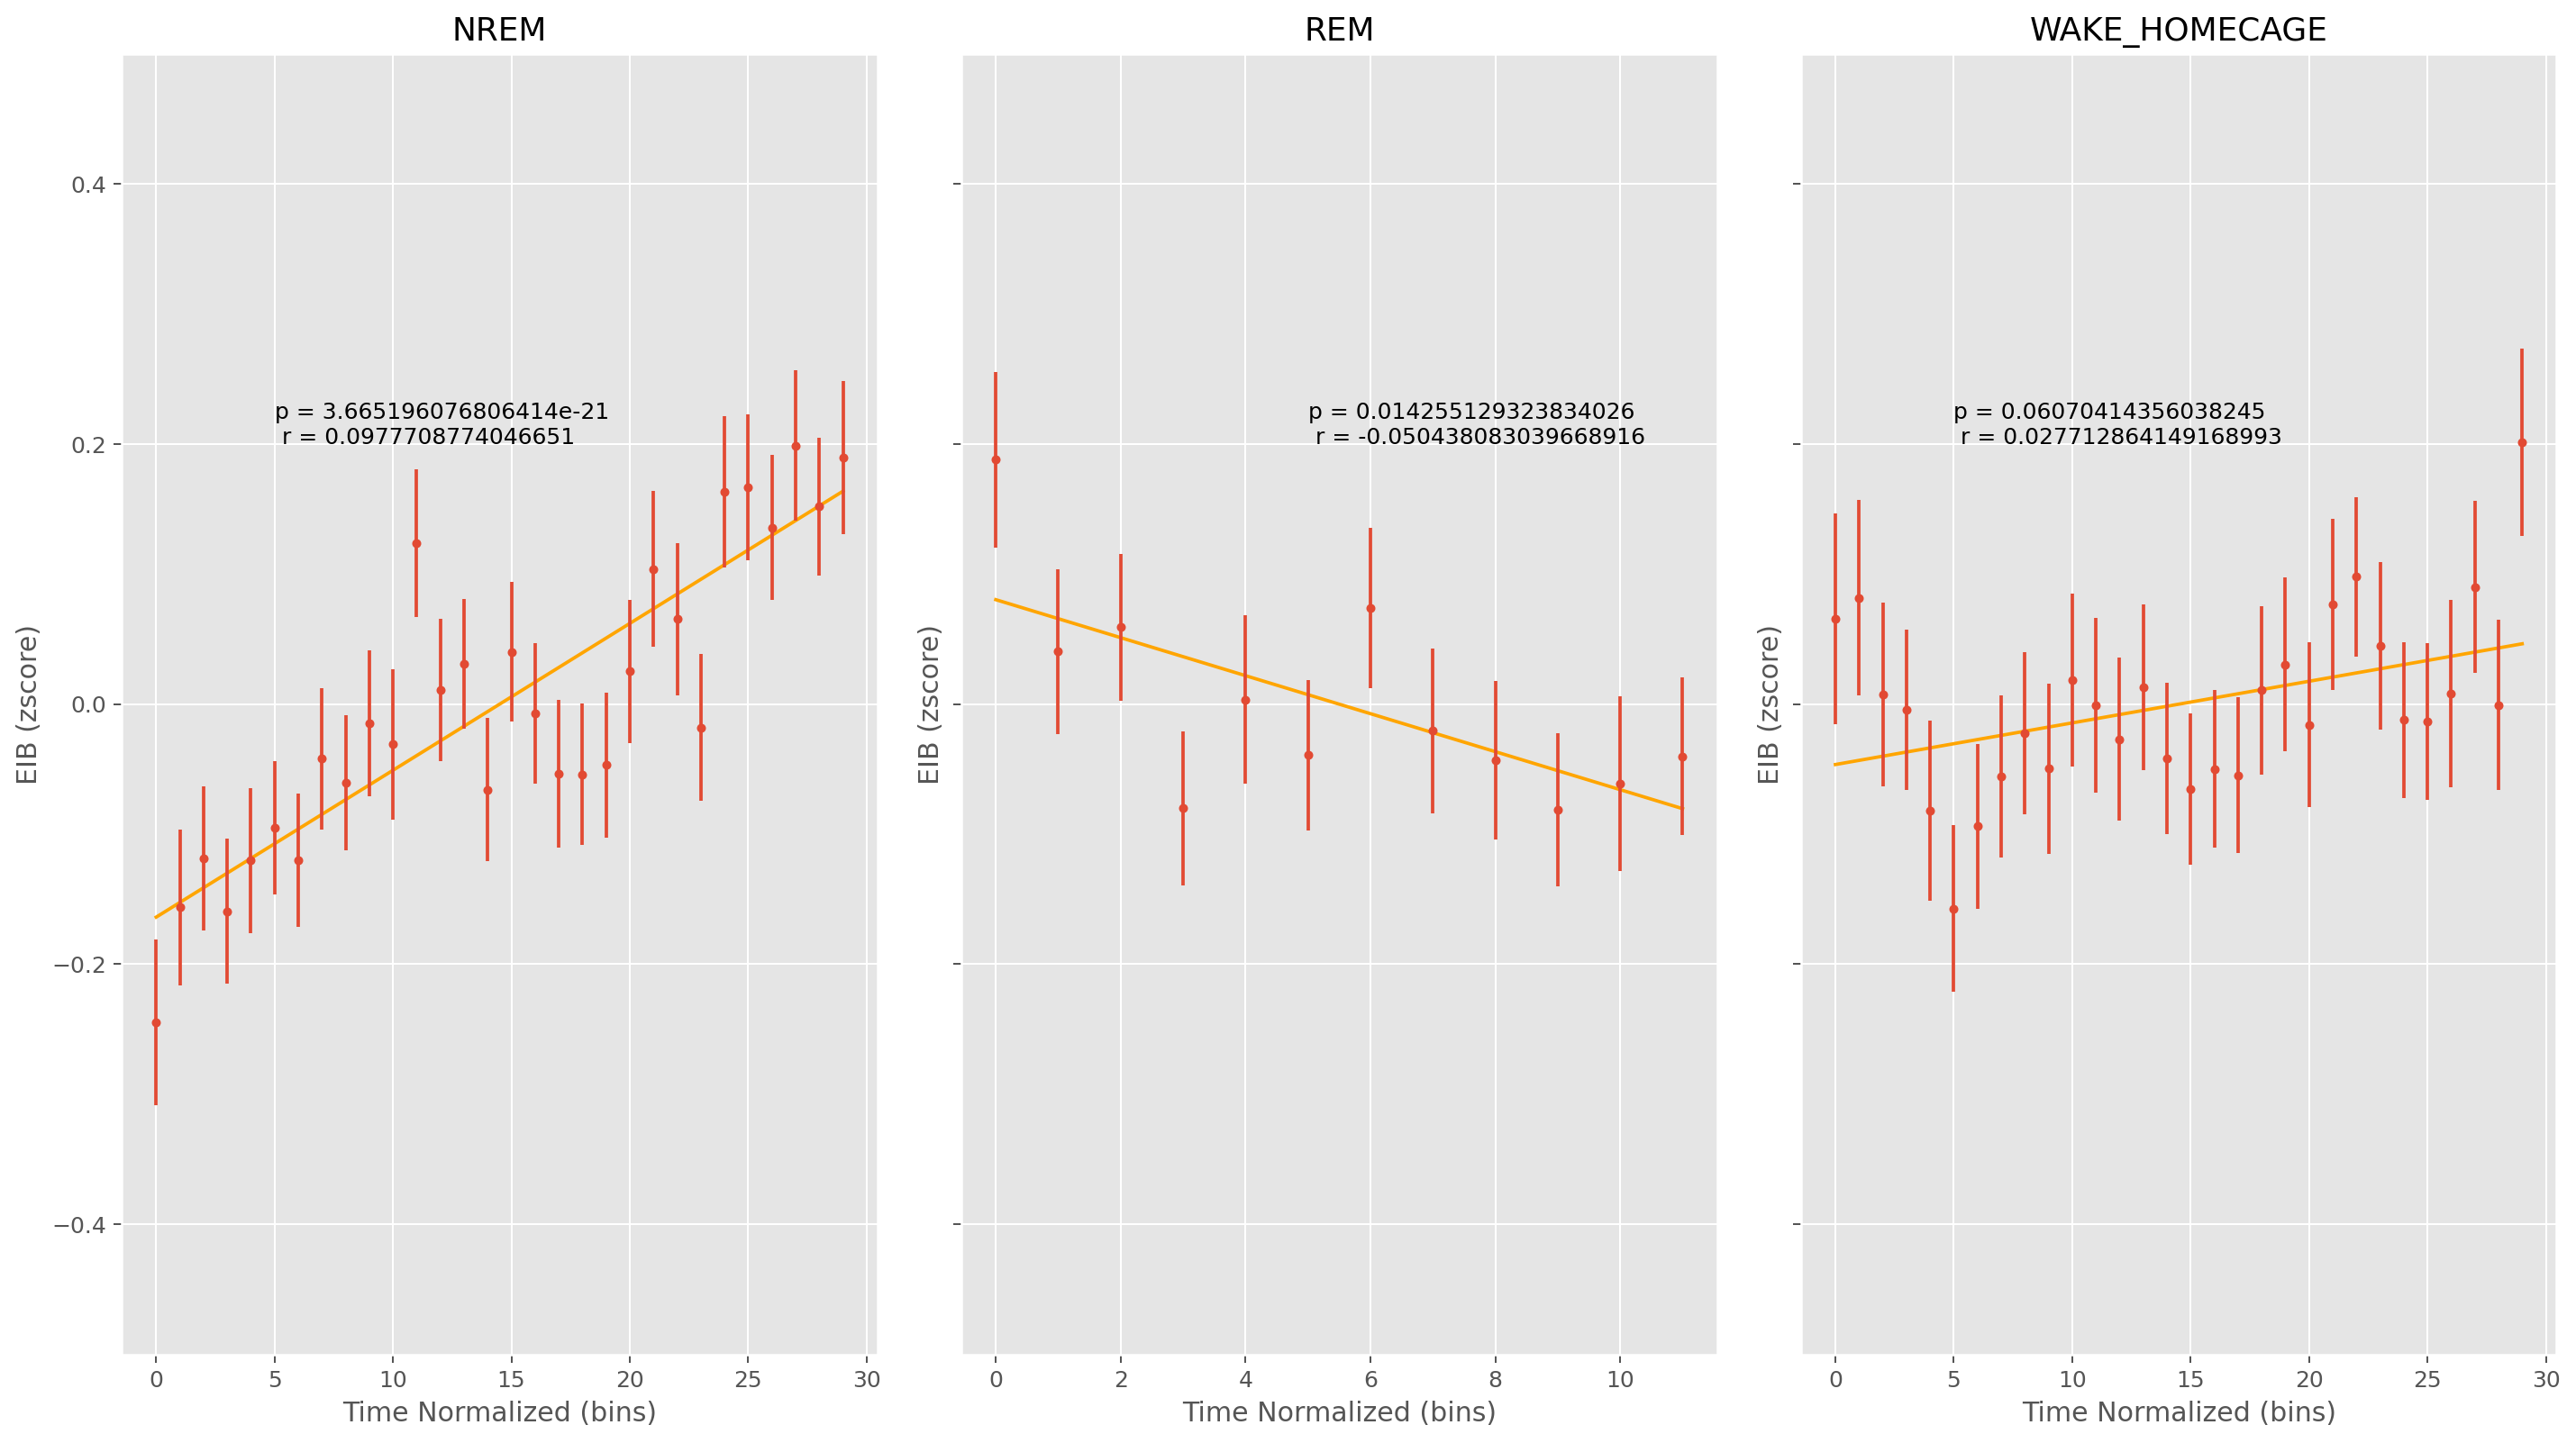

In [183]:
df = df_norm
fig,ax = plt.subplots(1,3,dpi = 180,sharey=True,figsize = (16,9))
for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    y = np.vstack(df.Dynamic[df.State == state].values)
    x = range(y.shape[1])

    # bk.plot.curve_and_shades(range(y.shape[1]),y,'sem',ax=ax[i])
    all_eib = np.array([[],[]])
    for j in y:
        all_eib = np.hstack((all_eib,np.array([x,j])))
        # ax[i].scatter(x,j,color = 'grey')
    

    means = [np.mean(all_eib[1,:][np.where(all_eib[0,:] == i)])for i in x]
    std = [scipy.stats.sem(all_eib[1,:][np.where(all_eib[0,:] == i)])for i in x]
    reg = scipy.stats.linregress(all_eib)


    print(state)
    print('R2',reg.rvalue**2)
    print('pValue (bonfer)',reg.pvalue*3)

    reg_y = (reg.slope * x) + reg.intercept
    ax[i].plot(x,reg_y,'orange')
    ax[i].errorbar(x,means,std,linestyle='None', marker='.')
    
    ax[i].set_title(state)
    ax[i].text(5,0.2,f'p = {reg.pvalue*3}\n r = {reg.rvalue}')
    ax[i].set_ylim(-0.5,0.5)
    ax[i].set_xlabel('Time Normalized (bins)')
    ax[i].set_ylabel('EIB (zscore)')
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/BLA_EIB_Different_States/eib_dynamic.svg')

100%|██████████| 61/61 [02:10<00:00,  2.14s/it]

['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 130.72623324394226
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', '

NREM
4.472149179593347e-11
7.005324038720113
REM
0.033460843318171826
-2.55612910257669
WAKE_HOMECAGE
0.8191663035064213
1.0986483524614041


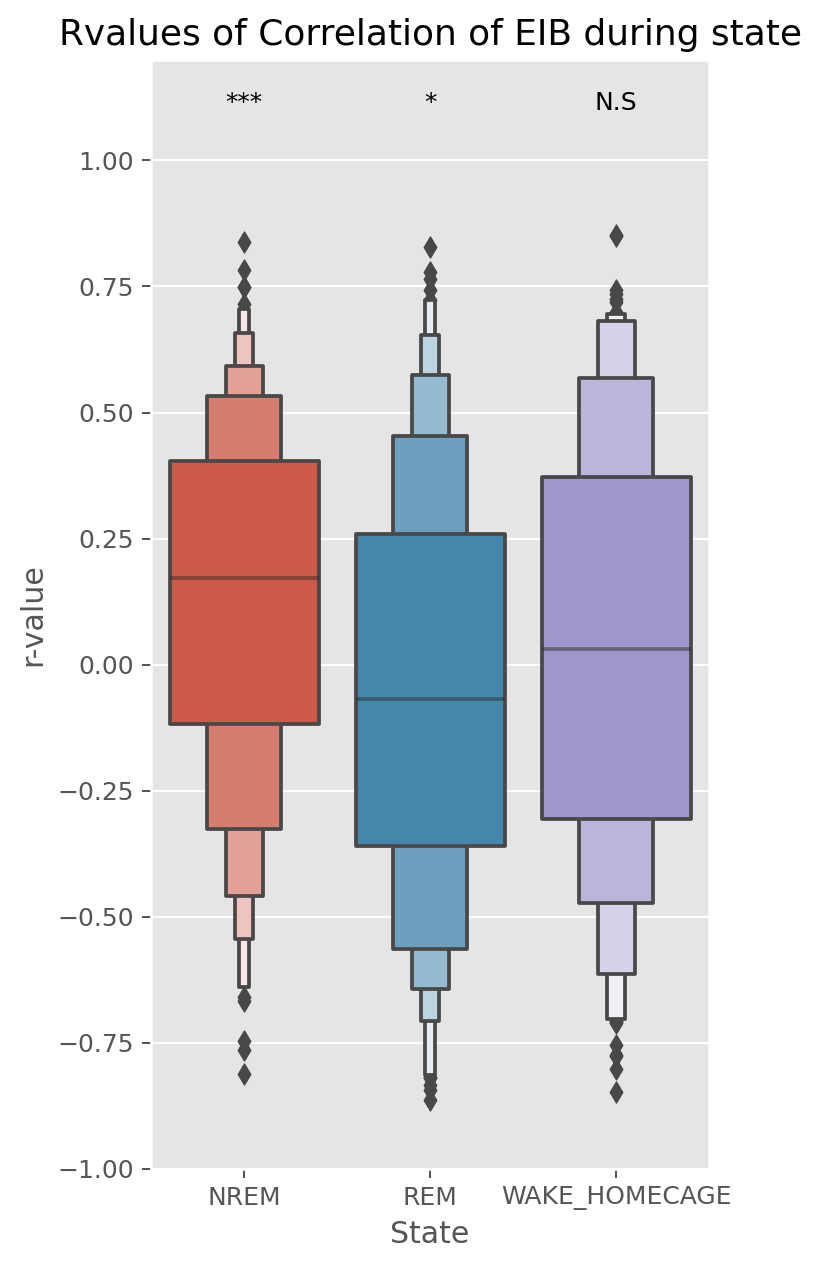

In [184]:
kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': 12,
              'NREM': 30,
              'WAKE_HOMECAGE': 30,
              'phREM': 5,
              'toREM': 5
          },
          'binSize':None,
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200,
              'phREM': 0,
              'toREM': 0
          },
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE': 0,
           'phREM': 0,
           'toREM': 0
           },
          'norm': True,
          'baseline': 'All',
          'as_tsd':False
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
# df = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
df = pd.concat(batch)


regress = {'slope': [],
           'intercept': [],
           'rvalue': []}
labels = []
dynamics = []

for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    y = np.vstack(df.Dynamic[df.State == state].values)
    for y_ in y:
        reg = scipy.stats.linregress(range(len(y_)),y_)
        labels.append(state)
        dynamics.append(y_)
        regress['slope'].append(reg.slope)
        regress['intercept'].append(reg.intercept)
        regress['rvalue'].append(reg.rvalue)    

df = pd.DataFrame(zip(dynamics, regress['slope'], regress['intercept'], regress['rvalue'], labels), columns=[
                  'Dynamics', 'Slope', 'Intercept', 'r-value', 'State'])
                  
pvalues = {}
for state in df['State'].unique():
    print(state)
    ttest = scipy.stats.ttest_1samp(df['r-value'][df.State == state],0)
    print(ttest.pvalue * 3)
    print(ttest.statistic)
    pvalues[state] = bk.stats.formatting_pvalues(np.array(scipy.stats.ttest_1samp(df['r-value'][df.State == state],0).pvalue*3))

plt.figure(figsize = (4,8),dpi = 180)
sns.boxenplot(data = df,x = 'State',y = 'r-value',order = ['NREM','REM','WAKE_HOMECAGE'])
plt.ylim(-1,1.2)
plt.title('Rvalues of Correlation of EIB during state')

for i,state in enumerate(df['State'].unique()): plt.text(i,1.1,pvalues[state],horizontalalignment = 'center')
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/EIB/Parts/ravlues.svg')    

100%|██████████| 61/61 [02:33<00:00,  2.51s/it]

['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 153.07773542404175
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', '

NREM
1.6429458043743233e-10
6.792575965509866
REM
0.06435305803164272
-2.313941370225902
WAKE_HOMECAGE
0.6765400354652459
1.2152168398976932


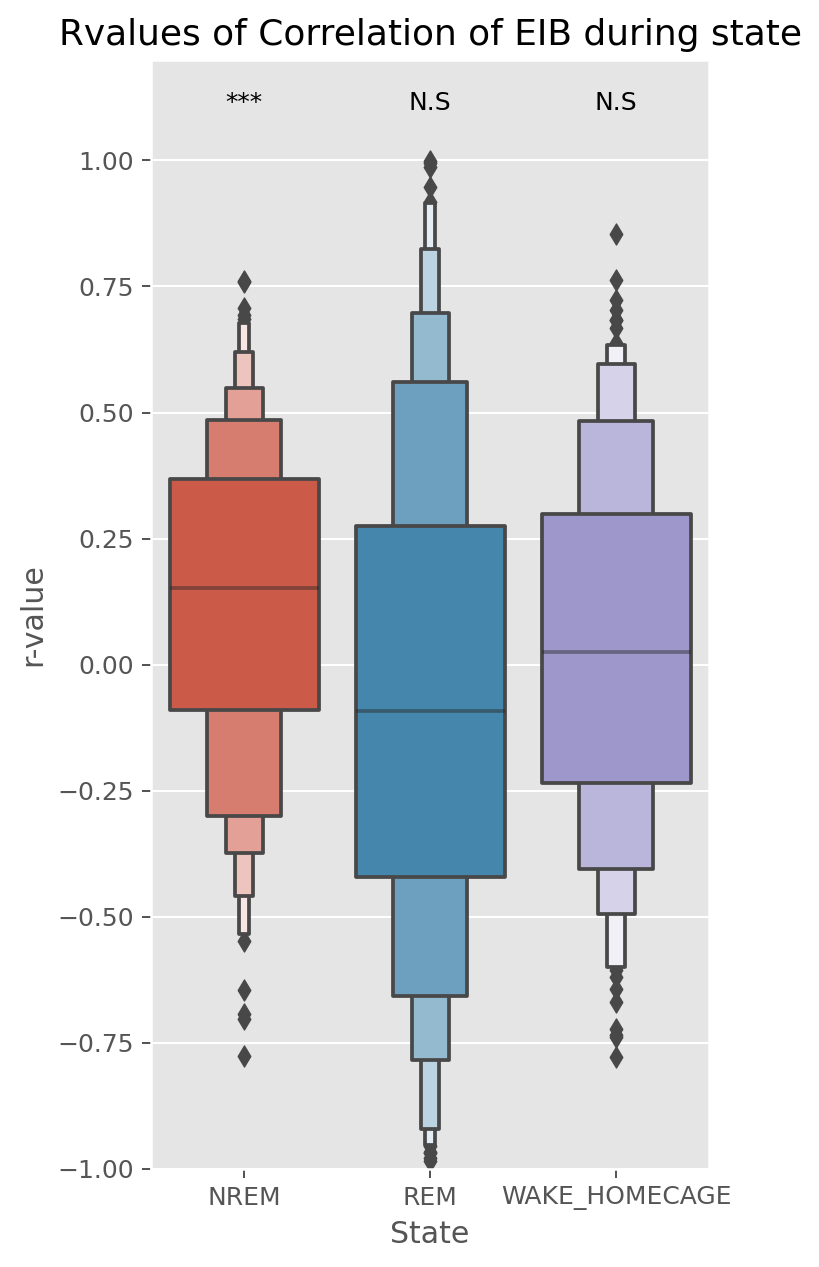

In [186]:
kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': None,
              'NREM': None,
              'WAKE_HOMECAGE': None,
              'phREM': None,
              'toREM': None
          },
          'binSize':10,
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200,
              'phREM': 0,
              'toREM': 0
          },
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE': 0,
           'phREM': 0,
           'toREM': 0
           },
          'norm': False,
          'baseline': None,
          'as_tsd':True
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
# df = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
df = pd.concat(batch)


regress = {'slope': [],
           'intercept': [],
           'rvalue': []}
labels = []
dynamics = []

for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    y = df.Dynamic[df.State == state]
    for y_ in y:
        t_ = y_.times('s')
        y_ = y_.values

        reg = scipy.stats.linregress(t_,y_)
        labels.append(state)
        dynamics.append(y_)
        regress['slope'].append(reg.slope)
        regress['intercept'].append(reg.intercept)
        regress['rvalue'].append(reg.rvalue)        

df = pd.DataFrame(zip(dynamics, regress['slope'], regress['intercept'], regress['rvalue'], labels), columns=[
                  'Dynamics', 'Slope', 'Intercept', 'r-value', 'State'])


pvalues = {}
for state in df['State'].unique():
    print(state)
    ttest = scipy.stats.ttest_1samp(df['r-value'][df.State == state],0)
    print(ttest.pvalue * 3)
    print(ttest.statistic)
    pvalues[state] = bk.stats.formatting_pvalues(np.array(scipy.stats.ttest_1samp(df['r-value'][df.State == state],0).pvalue*3))

plt.figure(figsize = (4,8),dpi = 180)
sns.boxenplot(data = df,x = 'State',y = 'r-value',order = ['NREM','REM','WAKE_HOMECAGE'])
plt.ylim(-1,1.2)
plt.title('Rvalues of Correlation of EIB during state')

for i,state in enumerate(df['State'].unique()): plt.text(i,1.1,pvalues[state],horizontalalignment = 'center')
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/BLA_EIB_Different_States/rvalues.svg')

In [9]:
def main(base_folder, local_path, *args, **kwargs):
    stru = kwargs['stru']
    norm = kwargs['norm']
    baseline = kwargs['baseline']

    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()

    if np.sum((metadata.Region == stru) & (metadata.Type == 'Int')) < 3:
        raise IndexError('Less than 3 interneurons')

    # if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<11:
    #     raise Exception('Not Enough Neurons')

    states = bk.load.states(True)
    extended_sleep = bk.compute.extended(states, 'sleep', 60*30, 60)

    if baseline == 'All':
        baseline_intervals = states['REM'].union(
            states['REM']).union(states['WAKE_HOMECAGE'])
    elif baseline == 'epochs':
        norm = False
        baseline_intervals = None

    elif baseline is not None:
        baseline_intervals = states[baseline]
    else:
        baseline_intervals = None
    if norm:
        baseline_eib = compute_eib(neurons, metadata, start=0, stop=None,
                                   binSize=10, stru=stru, as_tsd=True).restrict(baseline_intervals)
        mean = np.nanmean(baseline_eib)
        std = np.nanstd(baseline_eib)

    for s in ['wake', 'drowsy']:
        states.pop(s)

    df = pd.DataFrame()
    for state in ['NREM', 'REM']:
        for s, e in extended_sleep.iloc:
            current_sleep = nts.IntervalSet(s, e)
            first = states[state].intersect(current_sleep)[0:1]
            last = states[state].intersect(current_sleep)[-1:]

            first = {'start': first.as_units('s').start.values[0],
                     'end': first.as_units('s').end.values[0]}
            last = {'start': last.as_units('s').start.values[0],
                    'end': last.as_units('s').end.values[0]}
            first_eib = compute_eib(
                neurons, metadata, stru, first['start'], first['end'], nbins=1)[0]
            last_eib = compute_eib(
                neurons, metadata, stru, last['start'], last['end'], nbins=1)[0]
            if norm:
                first_eib = (first_eib-mean)/std
                last_eib = (last_eib-mean)/std
            df_ = pd.DataFrame([[first_eib, last_eib, state]], columns=[
                               'First', 'Last', 'State'])
            df = pd.concat((df, df_))

    if baseline == 'epochs':
        kwargs['nbins'] = {'REM': 1,
                           'NREM': 1,
                           'WAKE_HOMECAGE': 1}
        kwargs['norm'] = False
        kwargs['baseline'] = None
        kwargs['min_duration'] = {'REM': 30,
                                  'NREM': 200,
                                  'WAKE_HOMECAGE': 200,
                                  'phREM': 0,
                                  'toREM': 0
                                  }
        kwargs['time_from_border'] = {'REM': 0,
                                      'NREM': 0,
                                      'WAKE_HOMECAGE': 0,
                                      'phREM': 0,
                                      'toREM': 0
                                      }
        kwargs['binSize'] = None
        kwargs['as_tsd'] = False
        df_ = main_general(base_folder, local_path, **kwargs)
        mean = np.mean(df_['EIB'])
        std = np.std(df_['EIB'])
        for c in ['First', 'Last']:
            df[c] = (df[c]-mean)/std

    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df['nPyr'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Pyr'))
    df['nInt'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Int'))

    return df


kwargs = {'stru': 'BLA',
          'norm': True,
          'baseline': 'epochs'
          }


bk.load.current_session_linux()
# eib = main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main, **kwargs)


100%|██████████| 61/61 [03:47<00:00,  3.73s/it]

Batch finished in 227.23055624961853
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130711', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140622', 'Rat10-20140624', 'Rat10-20140628', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150325', 'Rat11-20150328', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
72.1311475409836 %


In [10]:
df = pd.concat(batch)
df_melt = df.melt(id_vars='State',var_name='epoch',value_vars=['First','Last'],value_name='EIB')

In [12]:
pairs = [
    [('NREM', 'First'), ('NREM', 'Last')],
    [('REM', 'First'), ('REM', 'Last')]
]

In [24]:
for state in ['NREM','REM']:
    x = df.First[df['State']==state]
    y = df.Last[df['State']==state]
    print(state)
    print(scipy.stats.shapiro(x))
    print(scipy.stats.shapiro(y))


NREM
ShapiroResult(statistic=0.9003499746322632, pvalue=0.03554382920265198)
ShapiroResult(statistic=0.9412122964859009, pvalue=0.23025107383728027)
REM
ShapiroResult(statistic=0.9477540850639343, pvalue=0.30870550870895386)
ShapiroResult(statistic=0.9726263284683228, pvalue=0.7902370691299438)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM_First vs. REM_Last: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-1.764e-01
NREM_First vs. NREM_Last: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-4.969e-01


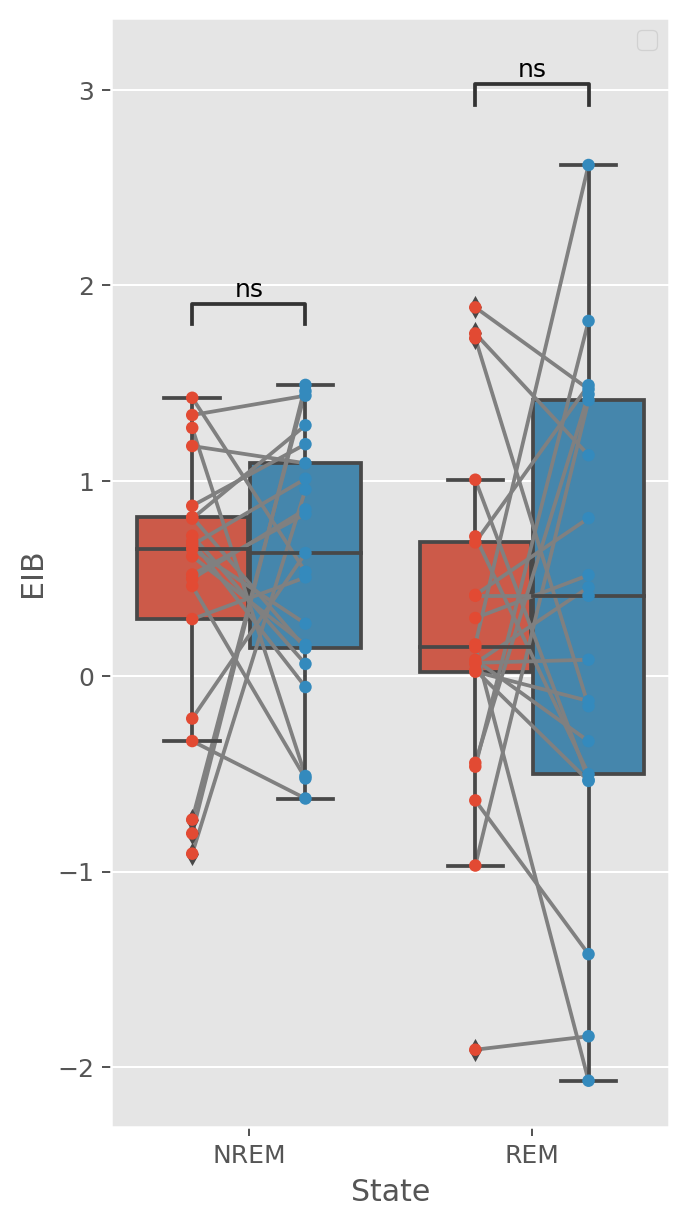

In [23]:
fig,ax = plt.subplots(figsize=(4,8),dpi = 180)
for i,s in enumerate(['NREM','REM']):
    values = np.array((df.First[df.State == s],df.Last[df.State == s]))
    n_values = values.shape[1]
    x = [[i-0.20]*n_values,[i+0.20]*n_values]
    plt.plot(x,values,'grey')

plotting_params = {'data': df_melt,
                   'y': 'EIB',
                   'x':'State',
                   'dodge':True,
                   'hue':'epoch',
                   'order':['NREM','REM'],
                   'ax':ax}
sns.boxplot(**plotting_params)
plotting_params['jitter'] = 0
sns.stripplot(**plotting_params)
annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="t-test_paired",comparisons_correction = 'Bonferroni').apply_and_annotate()
# sns.boxplot(data = df_melt,x = 'State',y = 'EIB',hue = 'epoch',dodge=True,order = ['NREM','REM'],ax = ax)
# sns.stripplot(data = df_melt,x = 'State',y = 'EIB',hue = 'epoch',dodge=True,order = ['NREM','REM'],jitter = 0,ax = ax)
plt.legend([])
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/EIB/Parts/EIB_extended_sleep.svg')

In [ ]:
def main(base_folder,local_path,**kwargs):
    stru = kwargs['stru']
    norm = kwargs['norm']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    
    if np.sum((metadata.Region == 'BLA') & (metadata.Type == 'Int')) <3:
        raise IndexError('Less than 5 interneurons')
    
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')

    states = bk.load.states(True)
    for s in ['wake','drowsy']: states.pop(s)
    
    baseline_intervals = states['NREM'].union(states['NREM']).union(states['WAKE_HOMECAGE'])
    baseline_eib = compute_eib(neurons,metadata,'BLA',binSize=2,as_tsd=True).restrict(baseline_intervals)

    # baseline_intervals = pd.concat((states['REM'],states['NREM'],states['WAKE_HOMECAGE']))
    # baseline_eib = eib_intervals(neurons,metadata,'BLA',baseline_intervals,1)
    baseline_mean = np.nanmean(baseline_eib)
    baseline_std = np.nanstd(baseline_eib)

    print(baseline_std)
    all_average_eib = {}
    for k,state in states.items():
        state = state.drop_short_intervals(50,time_units = 's').reset_index(drop = True)
        activity = bk.compute.bin_by_intervals(neurons,state,as_Tsd=True)
        e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
        i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
        all_average_eib[k] = (e_spikes)/(e_spikes+i_spikes)
        if norm: all_average_eib[k] = (all_average_eib[k] - baseline_mean)/baseline_std
    


    df = {}
    for state in states:
        df[state] = pd.DataFrame()
        df[state]['EIB'] = all_average_eib[state]
        df[state]['State'] = state
        print(df[state])
    df = pd.concat(df)
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df = df[['Rat','Day','State','EIB']].reset_index(drop = True)
    return df

In [ ]:
kwargs = {'stru':'BLA','norm':True}
batch,meta = bk.load.batch(main,**kwargs)
# main(bk.load.base,'Rat08/Rat08-20130712',**kwargs)

In [ ]:
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import levene

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.formula.api import gls
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
def anova(df, formula):
    lm = ols(formula, df).fit()
    anova_table = anova_lm(lm)
    print(anova_table)

    levene(df.EIB[df.State == 'NREM'],
           df.EIB[df.State == 'REM'],
           df.EIB[df.State == 'WAKE_HOMECAGE'])
    bartlett(df.EIB[df.State == 'NREM'],df.EIB[df.State == 'REM'])
    
    fig, ax = plt.subplot_mosaic('''
                                AAABBB
                                FFFGGG
                                CCDDEE''', dpi=180, figsize=(12, 12))
    sns.stripplot(data=df, x='State', y='EIB', ax=ax['A'],alpha = 0.65,s = 3)
    ax['A'].set_title('BOX PLOT EIB')
    ax['A'].set_ylim(-1,1)
    sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    ax['B'].set_title('QQPlot Residuals')

    sns.boxplot(data=df, x='Rat', y='EIB', ax=ax['F'])
    sns.boxplot(data=df, x='Day', y='EIB', ax=ax['G'])

    for ax_, data in zip(['C', 'D', 'E'], np.unique(df.State)):
        sm.qqplot(df.EIB[df.State == data], ax=ax[ax_], fit=True, line='45')
        ax[ax_].set_title(f'QQPlot {data}')
    plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['EIB'], df['State'], alpha=0.05)
    print(m_comp.summary())
    print(m_comp.pvalues)

df = pd.concat(batch)
formula = 'EIB ~ C(State)'
anova(df,formula)
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/EIB/EIB_Strip.svg')

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (12,8),dpi = 180)

rats = [8,9,10,11]
k = 0
for i in ax:
    for j in i:
        sns.violinplot(data=df[df.Rat == rats[k]], x='State', y='EIB',ax = j)
        j.set_title(rats[k])
        k +=1

plt.tight_layout()


# Going to check EIB between theta on / theta off 

In [ ]:
from imports import *

In [ ]:
def discard_border(state, t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)


def compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=0.025, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons, start=start, stop=stop, nbins=nbins, as_Tsd=True)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values, 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values, 1)
    eib = e_spikes / (e_spikes + i_spikes)
    # eib[~np.isfinite(eib)] = np.nan
    
    if as_tsd: eib = nts.Tsd(activity.times(),eib)
    return eib

def eib_intervals(neurons,metadata,stru,intervals,nbins):
    if len(intervals) == 0:
        eib = np.empty(shape = nbins)
        eib.fill(np.nan)
        return eib
    
    intervals_eib_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        eib_ = compute_eib(neurons,metadata,start = s,stop = e,nbins = nbins,stru = stru)
        intervals_eib_matrix.append(eib_)
    
    return intervals_eib_matrix

In [ ]:
def main(base_folder,local_path,**kwargs):
    stru = kwargs['stru']
    norm = kwargs['norm']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    
    if np.sum((metadata.Region == 'BLA') & (metadata.Type == 'Int')) <5:
        raise IndexError('Less than 5 interneurons')
    
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')

    states = bk.load.states(True)
    for s in ['wake','drowsy']: states.pop(s)
    
    baseline_intervals = states['REM'] # Baseline only during REM sleep for thetain thetaout
    baseline_eib = compute_eib(neurons,metadata,'BLA',binSize=0.1,as_tsd=True).restrict(baseline_intervals)
    baseline_mean = np.nanmean(baseline_eib.values)
    baseline_std = np.nanstd(baseline_eib.values)


    # theta_intervals = bk.load.intervals('BLA_REM_theta_bouts')
    # off_theta_intervals = states['REM'].set_diff(theta_intervals)
    # phasic_tonic = bk.load.intervals('phasic_tonic')
    
    # intervals = {'theta':theta_intervals,
    #             'theta_off':off_theta_intervals,
    #             # **phasic_tonic,
    #             'REM':states['REM']}

    gamma_intervals = bk.load.analysis('Gamma/gamma_intervals')
    gamma_left = gamma_intervals['REM']['left']['intervals']
    gamma_right = gamma_intervals['REM']['right']['intervals']
    no_gamma = states['REM'].set_diff(gamma_right.union(gamma_left))
    
    intervals = {'gamma_left':gamma_left,
                'gamma_right':gamma_right,
                'no_gamma':no_gamma}
    #Sanitary check of intervals
    # fig,ax = plt.subplots(2,sharex=True)
    # bk.plot.intervals(theta_intervals,'orange',ax = ax[0])
    # bk.plot.intervals(off_theta_intervals,'grey',ax = ax[0])
    # bk.plot.intervals(phasic_tonic['toREM'],'grey',ax = ax[1])
    # bk.plot.intervals(phasic_tonic['phREM'],'orange', ax = ax[1])
    #     
    
    all_average_eib = {}
    for k,state in intervals.items():
        state = state.drop_short_intervals(100,time_units = 'ms').reset_index(drop = True)
        activity = bk.compute.bin_by_intervals(neurons,state,as_Tsd=True)
        e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
        i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
        all_average_eib[k] = (e_spikes)/(e_spikes+i_spikes)
        if norm: all_average_eib[k] = (all_average_eib[k] - baseline_mean)/baseline_std


    df = {}
    for state in intervals:
        df[state] = pd.DataFrame()
        df[state]['EIB'] = all_average_eib[state]
        df[state]['State'] = state
    df = pd.concat(df)
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df = df[['Rat','Day','State','EIB']].reset_index(drop = True)
    return df

In [ ]:
def anova(df, formula):

    lm = ols(formula, df).fit()
    anova_table = anova_lm(lm)
    print(anova_table)

    levene(df.EIB[df.State == 'NREM'],
           df.EIB[df.State == 'REM'],
           df.EIB[df.State == 'WAKE_HOMECAGE'])
    bartlett(df.EIB[df.State == 'NREM'],df.EIB[df.State == 'REM'])
    
    fig, ax = plt.subplot_mosaic('''
                                AAAABBBB
                                FFFFGGGG
                                CCDDEEHH''', dpi=180, figsize=(12, 12))
    sns.boxplot(data=df, x='State', y='EIB', ax=ax['A'])
    ax['A'].set_title('BOX PLOT EIB')
    sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    ax['B'].set_title('QQPlot Residuals')

    sns.boxplot(data=df, x='Rat', y='EIB', ax=ax['F'])
    sns.boxplot(data=df, x='Day', y='EIB', ax=ax['G'])

    for ax_, data in zip(['C', 'D', 'E','H'], np.unique(df.State)):
        sm.qqplot(df.EIB[df.State == data], ax=ax[ax_], fit=True, line='45')
        ax[ax_].set_title(f'QQPlot {data}')
    plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['EIB'], df['State'], alpha=0.05)
    print(m_comp.summary())
    print(m_comp.pvalues)

# df = pd.concat(batch)
# formula = 'EIB ~ C(State) + C(Rat)'
# anova(df,formula)


In [ ]:
kwargs = {'stru': 'BLA',
          'norm': True}
bk.load.current_session_linux()
# df = main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main,**kwargs)

In [ ]:
df = pd.concat(batch)
df = df[df.EIB.notna()]

In [ ]:
formula = 'EIB ~ C(State)'
anova(df,formula)

In [ ]:
from imports import * 

In [ ]:
bk.load.current_session_linux()
bk.load.current_session_linux(bk.load.base,'Rat10/Rat10-20140629')
neurons, metadata = bk.load.spikes()
states = bk.load.states(True)
states.pop('drowsy')
states.pop('wake')

masks = {}
masks['STRU_PYR'] = (metadata.Region == 'BLA') & (metadata.Type == 'Pyr')
masks['STRU_INT'] = (metadata.Region == 'BLA') & (metadata.Type == 'Int')

activity = bk.compute.binSpikes(neurons,10,as_Tsd=True)

fr = {}
for i in masks:
    fr[i] = nts.Tsd(activity.times(),np.sum(activity.values[:,masks[i]],1))

e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
eib = e_spikes / (e_spikes + i_spikes)
eib = nts.Tsd(activity.times(),eib)

In [ ]:
fig,ax  = plt.subplots()

# for c,type in zip(['g','k'],fr.keys()):
#     ax.plot(fr[type].as_units('s'),c,alpha = 0.8)
ax.plot(eib.as_units('s'),'orange')
for c,state in zip(['green','grey','orange'],states.keys()):
    bk.plot.intervals(states[state],c,ax = ax)
